In [149]:
import pandas as pd
import numpy as np
import umap
import seaborn as sns
from sklearn.decomposition import FastICA, PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN

# Process data and split into training and test set

## set seed for consistent random_state and reproducibility

In [72]:
random_seed = 999

In [73]:
#feature_matrix = pd.read_csv("feature_matrix.csv.gz", index_col=0)
metadata = pd.read_csv("metadata.csv.gz")

In [74]:
#feature_matrix.to_feather("feature_matrix.feather", compression="lz4")

In [75]:
#read_feather is faster
feature_matrix = pd.read_feather("feature_matrix.feather").T

## label the mixed ones as invasive

In [76]:
metadata.disease_subtype = ["invasive" if "mixed" in subtype else subtype for subtype in metadata.disease_subtype]

In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(feature_matrix, metadata.disease_subtype, 
                                                    test_size=0.3, 
                                                    stratify=metadata.disease_subtype, 
                                                    random_state=random_seed)

# Dimensionality reduction methods

In [78]:
def calculateReconstructionError(X, X_hat):
    return np.mean(np.sum(np.square(X - X_hat), axis=1))

## ICA

In [79]:
ica = FastICA(whiten="unit-variance", random_state=random_seed)
ica.fit(X_train)

FastICA(random_state=999)

In [80]:
X_train_ica = ica.transform(X_train)
X_test_ica = ica.transform(X_test)

In [81]:
X_train_reconstructed_ica = ica.inverse_transform(X_train_ica)
X_test_reconstructed_ica = ica.inverse_transform(X_test_ica)

In [82]:
ica_reconstruction_error_train = calculateReconstructionError(X_train, X_train_reconstructed_ica)
ica_reconstruction_error_test = calculateReconstructionError(X_test, X_test_reconstructed_ica)

In [83]:
print(ica_reconstruction_error_train)

3449.155723174583


In [84]:
print(ica_reconstruction_error_test)

3913.7365656232464


## UMAP

## UMAP with 2 components just for visualization

In [85]:
umap_transformer_visualize = umap.UMAP(n_components=2,
                 n_neighbors=25,
                random_state=random_seed,
                min_dist=0.03)
umap_transformer_visualize.fit(X_train)

/home/zhangh10/.local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.03, n_neighbors=25, random_state=999, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [86]:
umap_transformed_coords = pd.DataFrame(umap_transformer_visualize.transform(X_train), columns=["umap1", "umap2"])
umap_transformed_coords["subtype"] = Y_train.values

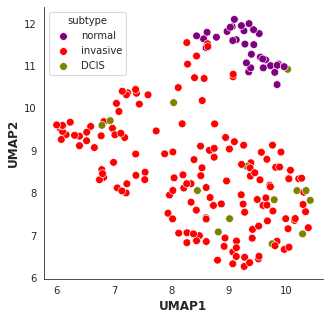

In [87]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5,5))
umap_visualize = sns.scatterplot(data=umap_transformed_coords, x="umap1", y="umap2",
               hue="subtype", palette="brg",
               s=60)
ax.set_xlabel("UMAP1", fontsize=12, weight="bold")
ax.set_ylabel("UMAP2", fontsize=12, weight="bold")
sns.despine()
plt.show()

In [88]:
fig.savefig("umap_visualize.png", dpi=500)

## UMAP for reducing dimensionality, increase n_components

In [89]:
umap_transformer = umap.UMAP(n_components=16,
                 n_neighbors=25,
                random_state=random_seed,
                min_dist=0.03)
umap_transformer.fit(X_train)

/home/zhangh10/.local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.03, n_components=16, n_neighbors=25, random_state=999, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [90]:
X_train_umap = umap_transformer.transform(X_train)
X_test_umap = umap_transformer.transform(X_test)

## Map CpGs to genes to reduce dimensionality

### This is done by taking the average DNAm over a 200bp window upstream of TSS. Transformation done in R using the package EpiSCORE

In [91]:
feature_mat_gene_level = pd.read_csv("feature_matrix_genelevel.csv.gz", index_col=0).T

In [92]:
X_train_gene = feature_mat_gene_level.loc[X_train.index]
X_test_gene = feature_mat_gene_level.loc[X_test.index]

# Baseline model

In [116]:
softmax_regressor = LogisticRegressionCV(penalty="l1",
                                      Cs=10,
                                      solver="saga",
                                      random_state=random_seed,
                                      max_iter=10**4,
                                      n_jobs=25,
                                        cv=5,
                                        scoring="f1_macro")

## Function to plot confusion matrix

In [117]:
def plotConfusionMatrix(y_true, y_pred, title):
    sns.set_style("white")
    confusionmat = ConfusionMatrixDisplay.from_predictions(y_true, 
                                        y_pred,
                                       cmap=plt.cm.Reds)
    confusionmat.ax_.set_xlabel("Predicted Label", fontsize=12, weight="bold")
    confusionmat.ax_.set_ylabel("True Label", fontsize=12, weight="bold")
    confusionmat.ax_.set_title(title, fontsize=15, weight="bold")
    plt.show()

## ICA performance on baseline model

In [118]:
softmax_regressor.fit(X_train_ica, Y_train)
predicted_baseline_ica = softmax_regressor.predict(X_test_ica)

In [119]:
accuracy_score(Y_train, softmax_regressor.predict(X_train_ica))

0.7638190954773869

In [120]:
accuracy_score(Y_test, predicted_baseline_ica)

0.7558139534883721

In [121]:
f1_score(Y_train, softmax_regressor.predict(X_train_ica), average="macro")

0.288698955365622

In [122]:
f1_score(Y_test, predicted_baseline_ica, average="macro")

0.28697571743929357

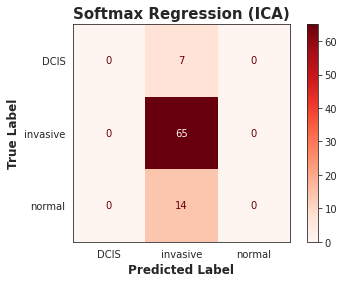

In [123]:
plotConfusionMatrix(Y_test, predicted_baseline_ica, "Softmax Regression (ICA)")

## UMAP performance on baseline model

In [158]:
softmax_regressor.fit(X_train_umap, Y_train)
predicted_baseline_umap = softmax_regressor.predict(X_test_umap)

In [159]:
accuracy_score(Y_train, softmax_regressor.predict(X_train_umap))

0.9195979899497487

In [160]:
accuracy_score(Y_test, predicted_baseline_umap)

0.8953488372093024

In [161]:
f1_score(Y_train, softmax_regressor.predict(X_train_umap), average="macro")

0.640792785903196

In [162]:
f1_score(Y_test, predicted_baseline_umap, average="macro")

0.77503478433711

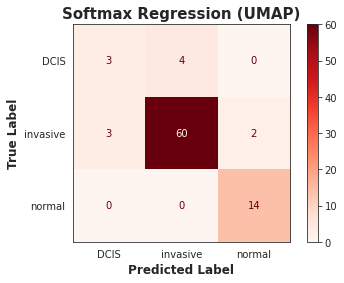

In [129]:
plotConfusionMatrix(Y_test, predicted_baseline_umap, "Softmax Regression (UMAP)")

## Gene-level feature matrix performance on baseline model

In [130]:
softmax_regressor.fit(X_train_gene, Y_train)
predicted_baseline_gene = softmax_regressor.predict(X_test_gene)

In [131]:
accuracy_score(Y_train, softmax_regressor.predict(X_train_gene))

1.0

In [132]:
accuracy_score(Y_test, predicted_baseline_gene)

0.9418604651162791

In [133]:
f1_score(Y_train, softmax_regressor.predict(X_train_gene), average="macro")

1.0

In [134]:
f1_score(Y_test, predicted_baseline_gene, average="macro")

0.8359535201640464

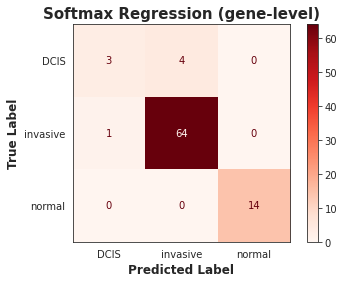

In [135]:
plotConfusionMatrix(Y_test, predicted_baseline_gene, "Softmax Regression (gene-level)")

# The gene-level feature matrix seems to have the best performance and is the most interpretable. Only downside is training time (13k features).

# Decided to use PCA

In [136]:
pca = PCA()
pca.fit(X_train)

PCA()

In [137]:
count = 0
for var in np.cumsum(pca.explained_variance_ratio_):
    count+=1
    if var >= 0.95:
        print(count)
        break

146


In [138]:
transformed_X_test = pca.transform(X_test)[:, :count]
transformed_X_train = pca.transform(X_train)[:, :count]

# Random Forest Classifier

In [139]:
rf_classifier = RandomForestClassifier()
param_grid_rf = {"n_estimators": np.arange(50, 1050, 150),
                "max_depth": [10, 30, 50, 70, 90, 110, 130, None],
                "min_samples_split": np.arange(2, 10, 2),
                 "min_samples_leaf": np.arange(1, 10, 2),
                 "max_features": ["sqrt", "log2"]}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
rf_grid_search = RandomizedSearchCV(rf_classifier, param_grid_rf, n_iter=60, scoring='f1_macro', n_jobs=-1, cv=cv, refit=True, verbose=True)

In [140]:
rf_grid_search.fit(transformed_X_train, Y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=999, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=60, n_jobs=-1,
                   param_distributions={'max_depth': [10, 30, 50, 70, 90, 110,
                                                      130, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([1, 3, 5, 7, 9]),
                                        'min_samples_split': array([2, 4, 6, 8]),
                                        'n_estimators': array([ 50, 200, 350, 500, 650, 800, 950])},
                   scoring='f1_macro', verbose=True)

In [141]:
predicted_rf = rf_grid_search.best_estimator_.predict(transformed_X_test)
f1_score(Y_test, predicted_rf, average="macro")

0.8571446956924621

In [156]:
roc_auc_score(Y_test, rf_grid_search.best_estimator_.predict_proba(transformed_X_test), average="macro", multi_class="ovo")

0.8924646781789639

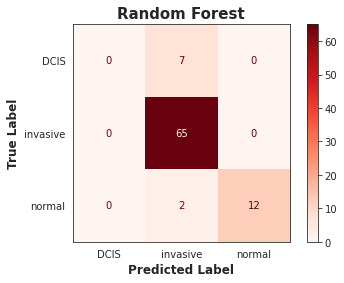

In [142]:
plotConfusionMatrix(Y_test, predicted_rf, "Random Forest")

# SVM

In [151]:
svm = SVC(probability=True)
param_grid_svm = {"C": np.logspace(-2, 2, num=50),
                 "gamma": np.logspace(-2, 2, num=20),
                  "degree": np.arange(2, 7),
                 "kernel": ["rbf", "linear"]}
svm_grid = RandomizedSearchCV(svm, param_grid_svm, n_iter=60, scoring='f1_macro', n_jobs=-1, cv=cv, refit=True, verbose=True)

In [152]:
svm_grid.fit(transformed_X_train, Y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=999, shuffle=True),
                   estimator=SVC(probability=True), n_iter=60, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7.90604321e-02,
       9.540...
                                        'gamma': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
                                        'kernel': ['rbf', 'linear']},
                   scoring='f1_macro', verbose=True)

In [153]:
predicted_svm = svm_grid.best_estimator_.predict(transformed_X_test)
f1_score(Y_test, predicted_svm, average="macro")

0.7087872185911402

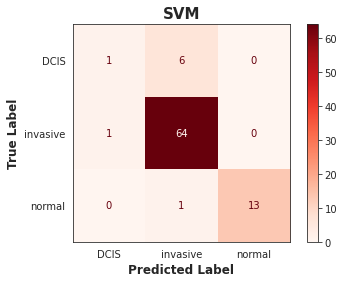

In [154]:
plotConfusionMatrix(Y_test, predicted_svm, "SVM")

In [155]:
roc_auc_score(Y_test, svm_grid.best_estimator_.predict_proba(transformed_X_test), average="macro", multi_class="ovo")

0.9429879644165359

# Try SMOTE

In [30]:
smote_model = ADASYN(n_neighbors=3, random_state=random_seed, n_jobs=-1, sampling_strategy="minority")

In [31]:
X_train_resampled, Y_train_resampled = smote_model.fit_resample(X_train, Y_train)

/home/zhangh10/.local/lib/python3.9/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [32]:
pca = PCA()
pca.fit(X_train_resampled)

PCA()

In [33]:
count = 0
for var in np.cumsum(pca.explained_variance_ratio_):
    count+=1
    if var >= 0.95:
        print(count)
        break

132


In [34]:
transformed_X_test = pca.transform(X_test)[:, :count]
transformed_X_train_resampled = pca.transform(X_train_resampled)[:, :count]

# Gaussian NB with SMOTE

In [62]:
gaussian_nb = GaussianNB()
param_grid_nb = {"var_smoothing": np.logspace(0, -9, num=500)}
gaussian_nb_grid = GridSearchCV(estimator=gaussian_nb, param_grid=param_grid_nb, cv=10, n_jobs=-1)

In [64]:
gaussian_nb_grid.fit(transformed_X_train_resampled, Y_train_resampled)

GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 9.59320948e-01, 9.20296681e-01, 8.82859884e-01,
       8.46945981e-01, 8.12493021e-01, 7.79441575e-01, 7.47734631e-01,
       7.17317494e-01, 6.88137699e-01, 6.60144909e-01, 6.33290840e-01,
       6.07529169e-01, 5.82815458e-01, 5.59107078e-01, 5.36363132e-01,
       5.14544388e-01, 4.936132...
       2.59913992e-09, 2.49340937e-09, 2.39197984e-09, 2.29467637e-09,
       2.20133111e-09, 2.11178304e-09, 2.02587771e-09, 1.94346693e-09,
       1.86440853e-09, 1.78856616e-09, 1.71580899e-09, 1.64601150e-09,
       1.57905331e-09, 1.51481892e-09, 1.45319752e-09, 1.39408283e-09,
       1.33737286e-09, 1.28296980e-09, 1.23077980e-09, 1.18071285e-09,
       1.13268257e-09, 1.08660611e-09, 1.04240401e-09, 1.00000000e-09])})

In [66]:
predicted_gaussianNB = gaussian_nb_grid.best_estimator_.predict(transformed_X_test)

In [67]:
f1_score(Y_test, predicted_gaussianNB, average="weighted")

0.5877730796335449

# SVM with SMOTE

In [57]:
svm = SVC()
param_grid_svm = {"C": np.logspace(-2, 2, num=50),
                 "gamma": np.logspace(-2, 2, num=20),
                  "degree": np.arange(2, 7),
                 "kernel": ["rbf", "linear"]}
svm_grid = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=10, n_jobs=-1)

In [58]:
svm_grid.fit(transformed_X_train_resampled, Y_train_resampled)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7.90604321e-02,
       9.54095476e-02, 1.15139540e-01, 1.38949549e-01, 1.67683294e-01,
       2.02358965e-01, 2.44205309e-01, 2.94705170e-...
                         'degree': array([2, 3, 4, 5, 6]),
                         'gamma': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
                         'kernel': ['rbf', 'linear']})

In [59]:
predicted_svm = svm_grid.best_estimator_.predict(transformed_X_test)
f1_score(Y_test, predicted_svm, average="weighted")

0.9231304132380148

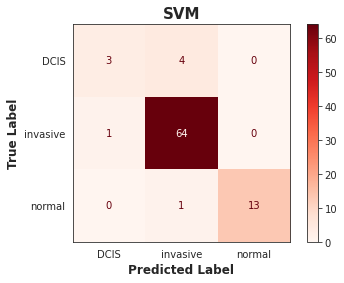

In [60]:
plotConfusionMatrix(Y_test, predicted_svm, "SVM")

# ADABOOST

In [35]:
adab = AdaBoostClassifier()
param_grid_adab = {"n_estimators": np.arange(50, 300, 40),
                  "learning_rate": np.logspace(-4, -1, num=20)}
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=random_seed)
adab_tuned = GridSearchCV(estimator=adab, param_grid=param_grid_adab, cv=cv, n_jobs=-1, verbose=True)

In [36]:
adab_tuned.fit(transformed_X_train_resampled, Y_train_resampled)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=999, test_size=0.1,
            train_size=None),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.0001    , 0.00014384, 0.00020691, 0.00029764, 0.00042813,
       0.00061585, 0.00088587, 0.00127427, 0.00183298, 0.00263665,
       0.00379269, 0.00545559, 0.0078476 , 0.01128838, 0.01623777,
       0.02335721, 0.03359818, 0.0483293 , 0.06951928, 0.1       ]),
                         'n_estimators': array([ 50,  90, 130, 170, 210, 250, 290])},
             verbose=True)

In [39]:
predicted_adab = adab_tuned.best_estimator_.predict(transformed_X_test)

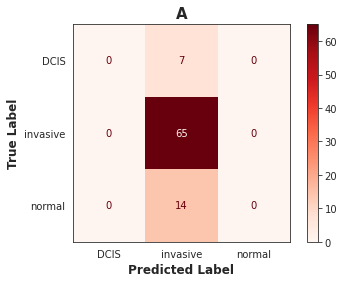

In [40]:
plotConfusionMatrix(Y_test, predicted_adab, "A")